## Customer Lifetime Value (CLV) Prediction

This project estimates **Customer Lifetime Value (CLV)** using transactional data from the Online Retail II (UCI) dataset.

CLV predicts the **future revenue contribution of each customer**, helping businesses:
- Identify high-value customers
- Optimize marketing spend
- Improve retention strategies

We use probabilistic models:
- **BG/NBD** for purchase frequency
- **Gamma-Gamma** for monetary value

In [6]:
import kagglehub
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

Using Colab cache for faster access to the 'online-retail-ii-uci' dataset.


In [7]:
!ls /kaggle/input/online-retail-ii-uci

online_retail_II.csv


## Installing Required Library

The **`lifetimes`** library is used for customer lifetime value (CLV) modeling.
It provides industry-standard probabilistic models such as:

- **BG/NBD** for predicting future purchase frequency  
- **Gamma-Gamma** for predicting average monetary value

In [14]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 15.5 MB/s eta 0:00:00


In [15]:
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

In [18]:
df = pd.read_csv("/kaggle/input/online-retail-ii-uci/online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Dataset Overview

The dataset contains transaction-level data including:
- Invoice dates
- Product quantities
- Prices
- Customer IDs

This data enables modeling repeat purchase behavior and customer value.

In [19]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


## Data Cleaning

To ensure accurate CLV calculations:
- Remove missing Customer IDs
- Remove cancelled transactions
- Remove negative quantity or price values

In [20]:
df = df.dropna(subset=['Customer ID'])
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

In [21]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [22]:
df['TotalAmount'] = df['Quantity'] * df['Price']

## Customer-Level Metrics

CLV models require customer-level data rather than transaction-level data.
We summarize each customer’s behavior using frequency, recency, age (T), and monetary value.

In [23]:
summary = summary_data_from_transaction_data(
    df,
    customer_id_col='Customer ID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalAmount',
    observation_period_end=df['InvoiceDate'].max()
)

summary.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,7.0,400.0,725.0,11066.637143
12347.0,7.0,402.0,404.0,717.398571
12348.0,4.0,363.0,438.0,449.310000
12349.0,3.0,571.0,589.0,1120.056667
12350.0,0.0,0.0,310.0,0.000000


## BG/NBD Model

The BG/NBD model predicts **how many times a customer will purchase again**
in a future time period based on past purchasing behavior.

In [24]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5878 subjects, a: 0.07, alpha: 63.11, b: 1.23, r: 0.67>

In [25]:
summary['predicted_purchases_6m'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180,
    summary['frequency'],
    summary['recency'],
    summary['T']
)

## Gamma-Gamma Model

The Gamma-Gamma model predicts the **average monetary value per transaction**
for each customer, assuming spending is independent of purchase frequency.

The Gamma-Gamma model requires that:
- Monetary value must be **strictly positive (> 0)**
- Customers must have made **at least one repeat purchase**

In [27]:
# Keep only customers with frequency > 0 and monetary_value > 0
summary_gg = summary[
    (summary['frequency'] > 0) &
    (summary['monetary_value'] > 0)
]

In [32]:
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(
    summary_gg['frequency'],
    summary_gg['monetary_value']
)

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 11.71, q: 0.88, v: 11.69>

## Predicting Average Order Value

After fitting the Gamma-Gamma model, we estimate the **expected average
monetary value per transaction** for each customer.

This represents how much a customer is expected to spend on a typical
future purchase and is a key component in calculating Customer Lifetime Value (CLV).

In [33]:
summary_gg['expected_avg_order_value'] = (
    ggf.conditional_expected_average_profit(
        summary_gg['frequency'],
        summary_gg['monetary_value']
    )
)

summary_gg.head()

,frequency,recency,T,monetary_value,predicted_purchases_6m,expected_avg_order_value
Customer ID,,,,,,
12346.0,7.0,400.0,725.0,11066.637143,1.086226,11084.664503
12347.0,7.0,402.0,404.0,717.398571,2.884955,720.130705
12348.0,4.0,363.0,438.0,449.310000,1.595674,453.402403
12349.0,3.0,571.0,589.0,1120.056667,0.976908,1127.835522
12352.0,8.0,356.0,392.0,338.261250,3.321059,340.161227


## Customer Lifetime Value (CLV) Calculation

Customer Lifetime Value (CLV) estimates the total revenue a customer is
expected to generate in the future.

CLV is calculated by combining:
- Predicted purchase frequency (BG/NBD model)
- Predicted average order value (Gamma-Gamma model)

In this project, we calculate CLV for a **6-month time horizon**.

In [34]:
summary_gg['CLV_6_months'] = ggf.customer_lifetime_value(
    bgf,
    summary_gg['frequency'],
    summary_gg['recency'],
    summary_gg['T'],
    summary_gg['monetary_value'],
    time=6,              # months
    discount_rate=0.01   # monthly discount rate
)

summary_gg.head()

,frequency,recency,T,monetary_value,predicted_purchases_6m,expected_avg_order_value,CLV_6_months
Customer ID,,,,,,,
12346.0,7.0,400.0,725.0,11066.637143,1.086226,11084.664503,11630.903262
12347.0,7.0,402.0,404.0,717.398571,2.884955,720.130705,2006.967764
12348.0,4.0,363.0,438.0,449.310000,1.595674,453.402403,698.901661
12349.0,3.0,571.0,589.0,1120.056667,0.976908,1127.835522,1064.333469
12352.0,8.0,356.0,392.0,338.261250,3.321059,340.161227,1091.320548


## CLV Segmentation

After calculating Customer Lifetime Value (CLV), customers are grouped into
segments based on their predicted future value.

CLV-based segmentation helps businesses:
- Identify high-value customers
- Prioritize retention strategies
- Allocate marketing budgets effectively

Customers are divided into four segments using quartiles:
- Low Value
- Mid Value
- High Value
- Very High Value

In [35]:
summary_gg['CLV_Segment'] = pd.qcut(
    summary_gg['CLV_6_months'],
    q=4,
    labels=['Low Value', 'Mid Value', 'High Value', 'Very High Value']
)

summary_gg[['CLV_6_months', 'CLV_Segment']].head()

,CLV_6_months,CLV_Segment
Customer ID,,
12346.0,11630.903262,Very High Value
12347.0,2006.967764,Very High Value
12348.0,698.901661,High Value
12349.0,1064.333469,Very High Value
12352.0,1091.320548,Very High Value


In [36]:
summary_gg['CLV_Segment'].value_counts()

,count
CLV_Segment,
Low Value,1048
Mid Value,1047
High Value,1047
Very High Value,1047


## CLV vs Purchase Frequency Analysis

To validate the CLV segmentation, we compare **purchase frequency**
across different CLV segments.

Since Customer Lifetime Value is influenced by how often a customer
purchases, higher CLV segments are expected to show higher purchase
frequency. This analysis helps confirm that the CLV model aligns with
real customer behavior and produces meaningful segments.

In [37]:
summary_gg.groupby('CLV_Segment')[['frequency', 'monetary_value', 'CLV_6_months']].mean()

,frequency,monetary_value,CLV_6_months
CLV_Segment,,,
Low Value,2.213740,199.229646,82.736150
Mid Value,3.005731,316.418277,259.366523
High Value,5.649475,393.435521,608.626939
Very High Value,15.135626,881.927698,3201.338417


## Distribution of Customer Lifetime Value (CLV)

This visualization shows how Customer Lifetime Value is distributed across
customers. CLV distributions are typically right-skewed, where a small
group of customers contributes most of the future revenue.

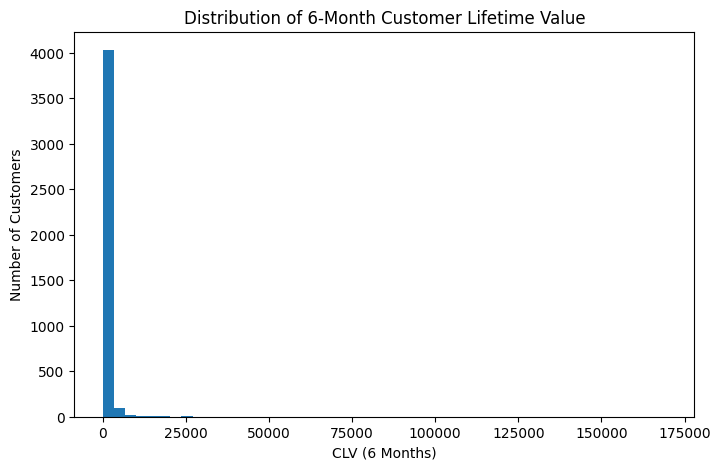

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(summary_gg['CLV_6_months'], bins=50)
plt.title("Distribution of 6-Month Customer Lifetime Value")
plt.xlabel("CLV (6 Months)")
plt.ylabel("Number of Customers")
plt.show()

## Interpretation of CLV Distribution

The CLV distribution is highly right-skewed, indicating that most customers
generate relatively low future revenue, while a small group of customers
contributes exceptionally high lifetime value.

This is a common and expected pattern in retail datasets and highlights
the importance of focusing retention and personalization efforts on
high-CLV customers.

## CLV by Customer Segment

This plot compares average CLV across different CLV segments,
highlighting how customers are clearly separated based on future value.

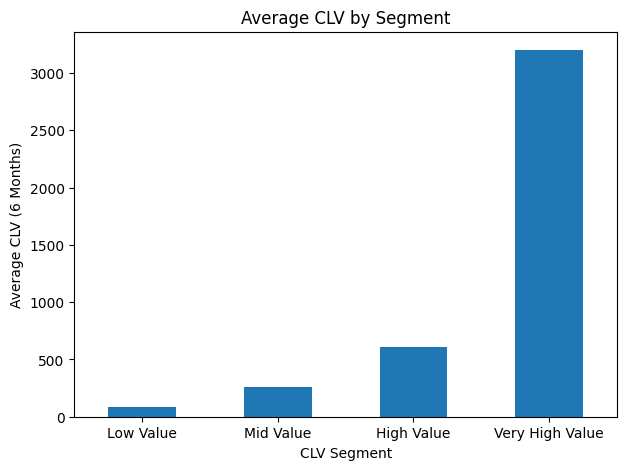

In [39]:
segment_clv = summary_gg.groupby('CLV_Segment')['CLV_6_months'].mean()

plt.figure(figsize=(7,5))
segment_clv.plot(kind='bar')
plt.title("Average CLV by Segment")
plt.xlabel("CLV Segment")
plt.ylabel("Average CLV (6 Months)")
plt.xticks(rotation=0)
plt.show()

## Average CLV by Segment

This chart clearly shows increasing average CLV across segments,
confirming that the segmentation effectively separates customers
based on future value.

The Very High Value segment contributes the highest predicted revenue
and should be prioritized for retention and loyalty strategies.

## Relationship Between Purchase Frequency and CLV

This visualization explores the relationship between how often customers
purchase and their predicted lifetime value. Higher purchase frequency
is generally associated with higher CLV.

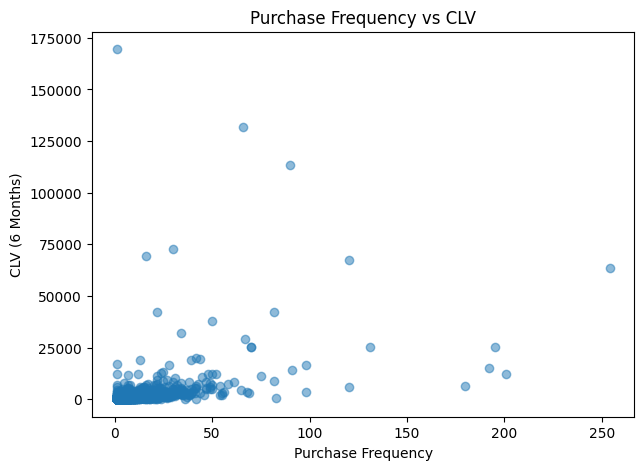

In [40]:
plt.figure(figsize=(7,5))
plt.scatter(
    summary_gg['frequency'],
    summary_gg['CLV_6_months'],
    alpha=0.5
)
plt.title("Purchase Frequency vs CLV")
plt.xlabel("Purchase Frequency")
plt.ylabel("CLV (6 Months)")
plt.show()

## Purchase Frequency vs CLV

This visualization highlights a strong positive relationship between
purchase frequency and Customer Lifetime Value.

Customers who purchase more frequently tend to have significantly higher
predicted CLV, reinforcing the importance of repeat purchases in long-term revenue.

## Relationship Between Monetary Value and CLV

This plot shows how average spending per transaction influences
Customer Lifetime Value.

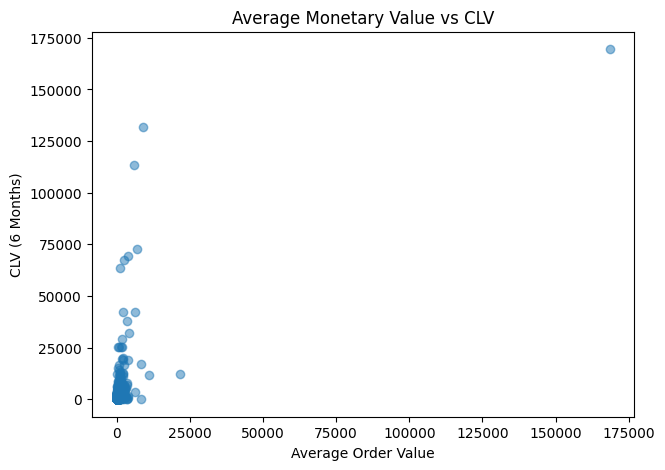

In [41]:
plt.figure(figsize=(7,5))
plt.scatter(
    summary_gg['monetary_value'],
    summary_gg['CLV_6_months'],
    alpha=0.5
)
plt.title("Average Monetary Value vs CLV")
plt.xlabel("Average Order Value")
plt.ylabel("CLV (6 Months)")
plt.show()

## Average Monetary Value vs CLV

This plot shows a positive relationship between average order value and
Customer Lifetime Value. Customers who spend more per transaction tend
to generate higher future revenue.

The presence of a few high-value outliers indicates customers with
exceptionally high spending behavior, which significantly impacts overall CLV.

## Segment-wise Summary Statistics

This table summarizes key metrics for each CLV segment, helping compare
customer behavior and business value across segments.

In [42]:
summary_gg.groupby('CLV_Segment')[[
    'frequency',
    'monetary_value',
    'CLV_6_months'
]].mean()

,frequency,monetary_value,CLV_6_months
CLV_Segment,,,
Low Value,2.213740,199.229646,82.736150
Mid Value,3.005731,316.418277,259.366523
High Value,5.649475,393.435521,608.626939
Very High Value,15.135626,881.927698,3201.338417


## CLV Segmentation Analysis

The CLV-based segmentation clearly differentiates customers by their
future revenue potential.

### Key Observations

- **Low Value Customers**
  - Low purchase frequency and spending
  - Generate minimal future revenue
  - Suitable for low-cost or automated marketing strategies

- **Mid Value Customers**
  - Moderate purchase frequency and monetary value
  - Represent growth opportunities with targeted campaigns

- **High Value Customers**
  - Frequent buyers with strong spending behavior
  - Ideal candidates for loyalty programs and personalized offers

- **Very High Value Customers**
  - Smallest segment but contributes the highest future revenue
  - Extremely high frequency and monetary value
  - Must be prioritized for retention and premium engagement strategies

## Business Insight

The analysis shows that a small group of **Very High Value customers**
contributes a disproportionately large share of predicted future revenue.
Focusing retention and personalization efforts on these customers can
significantly improve overall business profitability.

## Key Takeaway

CLV segmentation provides more actionable insights than RFM alone by
shifting focus from past behavior to **future customer value**, enabling
data-driven marketing and retention decisions.

## Conclusion

This project successfully estimated **Customer Lifetime Value (CLV)** using
real-world transactional data from the Online Retail II dataset.

By applying probabilistic models (BG/NBD and Gamma-Gamma), we moved beyond
descriptive analysis and predicted **future customer value**. The results
showed that a small group of customers contributes a disproportionately
large share of expected future revenue.

CLV-based segmentation clearly differentiated customers into actionable
value groups, enabling targeted retention, personalized marketing, and
efficient allocation of marketing resources.

Overall, this project demonstrates how customer analytics can transform
raw transaction data into meaningful business insights that support
data-driven decision-making.